# Sentiment analysis: US airlines on Twitter
----

In this Natural Language Processing project, we predict the sentiment of tweets about different US airlines. We start by preprocessing the tweets (replacing emojis by text, removing hashtags and punctuation, converting to lowercase). We then encode each tweet to a vector of integers. We use a pre-trained GloVe embedding downloaded from [this source](https://nlp.stanford.edu/projects/glove/) and create a weights matrix of the words contained in the tweets. Finally, we build, train and compare the performance of two different Recurrent Neural Network models: a bidirectional GRU and a bidirectional LSTM.

The dataset we use is available [here](https://www.kaggle.com/bertcarremans/predicting-sentiment-with-text-features/data). It consists of 11,541 tweets scraped in February 2015 categorised as negative or positive.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import emoji
import re
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Bidirectional, GRU, LSTM, SpatialDropout1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [2]:
# loading the dataset
df= pd.read_csv("airline_tweets.csv")
df.head()

,airline_sentiment,text
0,positive,@VirginAmerica plus you've added commercials t...
1,negative,@VirginAmerica it's really aggressive to blast...
2,negative,@VirginAmerica and it's a really big bad thing...
3,negative,@VirginAmerica seriously would pay $30 a fligh...
4,positive,"@VirginAmerica yes, nearly every time I fly VX..."


Using Seaborn, let's have a look at the classes representation to pick an appropriate evaluation metric. 

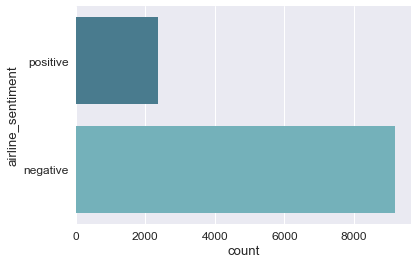

In [3]:
# visualising the number of negative/positive reviews
sns.set(font_scale=1.2)
sns.countplot(y="airline_sentiment", data=df, palette="GnBu_d")

Because the classes are imbalanced, we won't use accuracy as a metric to assess our models performance. Instead, we will compute their $F_1$ score.

We also map labels to 0 and 1 instead of "negative" and "positive".

In [4]:
# mapping labels
df["airline_sentiment"]= df["airline_sentiment"].map({"negative":0, "positive":1})

----
## Preprocessing tweets
A crucial step in Natural Language Processing projects is text preprocessing. In our case, most tweets contain hashtags and some contain emojis, as we can see from the two examples below.

In [5]:
# examples of tweets that need preprocessing
print(df["text"].iloc[14])
print(df["text"].iloc[261])

I ❤️ flying @VirginAmerica. ☺️👍
@VirginAmerica omg omg😍😍 nonstop Dallas to Austin on virgin✨😱✈️


Because emojis reflect the mood of the person using them, they can be very useful in our sentiment analysis. Instead of just removing them, we use emoji.demojize() to convert them to words.

In [6]:
# cleaning tweets 
def preprocess(df):
    # converting emojis to words
    tweet= emoji.demojize(df["text"])
    # removing words starting with @ and converting to lowercase
    words_without_at= []
    for w in tweet.split():
        if w.startswith("@"):
            continue
        else:
            words_without_at.append(str.lower(w))
    tweet= " ".join(words_without_at)
    # removing non-word characters
    words_list= re.findall("[\w]+", tweet)
    return " ".join(words_list)

df["text"]= df.apply(preprocess, axis=1)

In [7]:
# same examples after preprocessing
print(df["text"].iloc[14])
print(df["text"].iloc[261])

i red_heart flying smiling_face thumbs_up
omg omg smiling_face_with_heart eyes smiling_face_with_heart eyes nonstop dallas to austin on virgin sparkles face_screaming_in_fear airplane


Note that, because we are using Recurrent Neural Networks in this project, we keep the stop-words. RNNs are indeed able to handle these very common words (getting rid of them actually worsened the models performance, not shown in this notebook).

----
## Creating the weights matrix
We create a vocabulary with the Tokenizer tool from Keras, then encode each tweet into a vector of integers. We also set a maximum size of 25 words per tweet and pad short tweets with zeros. Note that the few tweets that are longer than 25 words will be truncated.

In [8]:
# preparing the tokenizer
tok= Tokenizer()
tok.fit_on_texts(df["text"])
vocab_size= len(tok.word_index)+1

# integer encoding
encoded_tweets= tok.texts_to_sequences(df["text"])

# padding reviews to a max length of 25 words (truncating reviews longer than 25)
tweet_len= 25
padded_tweets= pad_sequences(encoded_tweets, maxlen=tweet_len, padding="post")
padded_tweets.shape

(11541, 25)

Next, we load a pre-trained GloVe embedding downloaded from [here](https://nlp.stanford.edu/projects/glove/). It corresponds to a 400,000-word vocabulary where each word is represented by a 300-dimensional vector. We store it in a dictionary.

In [9]:
# loading the pre-trained GloVe embedding
embeddings_index= dict()
glove= open("glove.6B.300d.txt")
dimension= 300
for line in glove:
    values= line.split()
    word= values[0]
    coefs= np.asarray(values[1:], dtype="float32")
    embeddings_index[word]= coefs
glove.close()

Finally, we use the dictionary of pre-trained embeddings to create a matrix of weights for each word in the tweets.

In [10]:
# creating a weights matrix for each word in the tweets
embedding_matrix= np.zeros((vocab_size, dimension))
for word, index in tok.word_index.items():
    embedding_vector= embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]= embedding_vector

----
## Predicting tweet sentiment with RNNs
As mentioned previously, we cannot rely on accuracy to evaluate performance. We need to create a function that computes the $F_1$ score in order to be able to call it when compiling our models.

We also split the dataset.

In [11]:
# function to compute the F beta score (here beta=1)
def fb_score(y_true, y_pred):
    y_pred= K.clip(y_pred, 0, 1)
    true_pos= K.sum(K.round(y_true*y_pred)) + K.epsilon() #to avoid /0
    false_pos= K.sum(K.round(K.clip(y_pred-y_true, 0, 1)))
    false_neg= K.sum(K.round(K.clip(y_true-y_pred, 0, 1)))
    precision= true_pos / (true_pos+false_pos)
    recall= true_pos / (true_pos+false_neg)
    beta=1
    fb_score= (1+beta**2) * (precision*recall) / (beta**2*precision + recall + K.epsilon())
    return fb_score

# splitting the dataset
X_train, X_test, y_train, y_test= train_test_split(padded_tweets, df["airline_sentiment"], test_size=0.1, random_state=0)

### 1. Bidirectional GRU
For both models, we set `trainable=False` because our dataset is relatively small.

In [14]:
# building the GRU model
gru_model= Sequential()
gru_model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], trainable=False))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(Bidirectional(GRU(128, return_sequences=True)))
gru_model.add(GlobalMaxPooling1D())
gru_model.add(Dense(1, activation="sigmoid"))

# compiling
gru_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[fb_score])

# fitting
gru_model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)

# evaluating the GRU on the test set
gru_f1_score= gru_model.evaluate(X_test, y_test, batch_size=1)
print("Bidirectional GRU model F1 score on test set: ", gru_f1_score[1])

1155/1155 [==============================] - 8s 7ms/step
Bidirectional GRU model F1 score on test set:  0.933333346667


With such a bidirectional GRU model, we obtain an $F_1$ score of 93.33% on the test set. Let's see if a bidirectional LSTM can beat it.

### 2. Bidirectional LSTM

In [13]:
# building the LSTM model
lstm_model= Sequential() 
lstm_model.add(Embedding(vocab_size, dimension, weights=[embedding_matrix], trainable=False))
lstm_model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)))
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(64, activation="relu"))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation="sigmoid"))

# compiling
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[fb_score])

# fitting
lstm_model.fit(X_train, y_train, epochs=6, batch_size=64, verbose=0)

# evaluating the LSTM on the test set
lstm_f1_score= lstm_model.evaluate(X_test, y_test, batch_size=1)
print("Bidirectional LSTM model F1 score on test set: ", lstm_f1_score[1])

1155/1155 [==============================] - 9s 8ms/step
Bidirectional LSTM model F1 score on test set:  0.930735944589


This bidirectional LSTM model has an $F_1$ score of 93.07% on the test set. This is slightly less than the $F_1$ score of the bidirectional GRU model.

----
## Conclusion
In this sentiment classification project, we used a word embeddings approach to predict the sentiment of tweets regarding different US airlines. After preprocessing the tweets (replacing emojis by text, removing hashtags and punctuation, converting to lowercase), we encoded each of them to a vector of integers. We then took advantage of a pre-trained GloVe embedding to create a weights matrix of the tweets words. We built and trained two different Recurrent Neural Network models: a bidirectional GRU and a bidirectional LSTM. The best performance on the test set was achieved by the bidirectional GRU model with an $F_1$ score of 93.33%.
